# Setup and workflow configuration

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tools

# Print charts in the notebook, using retina graphics
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Setup seaborn graphs
sns.set_context("talk")
sns.set(style="darkgrid", color_codes=True)

verbose = False

# Project configuration
# Note: connection (domain, user, pass) can be set in .env file.
#       Values specified in the configuration overwrite .env values.
config_yaml = """
  connection:
    domain: http://ecosystem.atlassian.net
    username: __none__
    password: __none__

  criteria:
    project: AC
    issue types:
      - Support Request
      - Documentation
      - Improvement
      - Bug
      - New Feature
    valid resolutions:
      - Answered
      - Fixed

    jql: |
      created > -360d OR resolved > -360d

  attributes:
    priority: Priority
    components: Component/s
    story_points: Story Points

  workflow:
    Backlog:
      - Open
      - To Do
    Triage:
      - Triage
      - Under Review
    In Progress:
      - In Progress
    Done:
      - Closed
"""

# Fetch data from JIRA based on above configuration

In [158]:
# This can take some time. Set verbose to True to get some progress feedback.
q, cycle_data = tools.calc_cycle_data(config_yaml, verbose)

# Story points vs cycle times analysis

19 out of 152 issues have both not null story points and cycle time


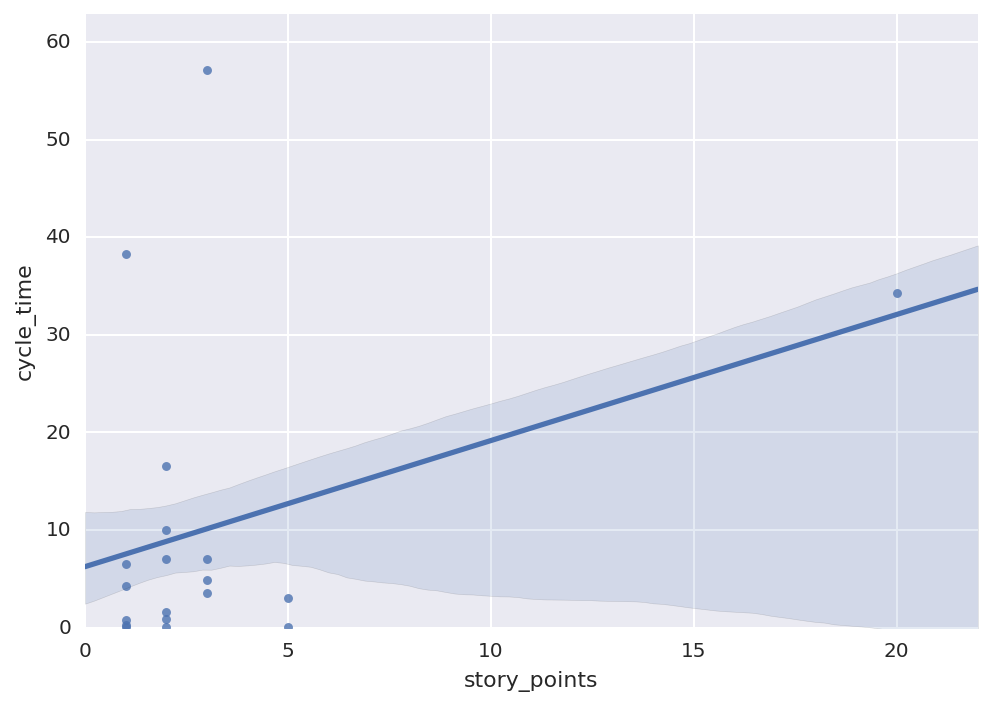

In [159]:
cd = cycle_data.dropna(axis='index', how='any', subset=['story_points', 'cycle_time']).copy()
print('{} out of {} issues have both not null story points and cycle time'.format(len(cd), len(cycle_data)))
# convert story_points into numeric values
cd.loc[:,'story_points'] = cd['story_points'].astype(int)
# convert 'cycle_time' to float representation of timedelta
cd.loc[:,'cycle_time'] = cd['cycle_time'].astype('timedelta64')
# nanoseconds to days
cd['cycle_time'] /= 1e+9 * 60*60*24
# set up axes limits
axes = plt.gca()
axes.set_xlim([0,cd['story_points'].max()*1.1])
axes.set_ylim([0,cd['cycle_time'].max()*1.1])
# plot scatter data with linear regression
g = sns.regplot(x="story_points", y="cycle_time", data=cd, ci=68, x_jitter=0, ax=axes)

In [160]:
# Caveat: cycle_time is NA for issues which never visited 'accepted' columns (i.e. columns other than first and last)
#cycle_data.loc[lambda df: (df['Done'].notnull() & df['cycle_time'].isnull())]

# Calculate times spent in columns

In [161]:
from pandas import Timedelta

workflow_cols = cycle_data.loc[:,'completed_timestamp':].columns[1:]
workflow_cols[:-1]

def reduce(row, time_spent):
    duration = Timedelta('nat')
    if pd.notnull(row[0]):
        # there's at least 2 values in row
        for v in row[1:]:
            if not pd.isnull(v):
                duration = v - row[0]
                break
    time_spent.append(duration)

# DataFrame with issue keys and time spent 
time_spent_df = pd.DataFrame()
time_spent_df['key'] = cycle_data['key']

for col in workflow_cols[:-1]: # skip the last column - done
    # select columns with last workflow columns
    df = cycle_data.loc[:,col:]
    time_spent = []
    df.apply(reduce, axis='columns', time_spent=time_spent)
    time_spent_df[col] = time_spent
    time_spent_df.loc[:,col] = time_spent_df[col].astype('timedelta64[ns]')

## Stats on times spent in columns

In [162]:
# Print some results
print(time_spent_df.iloc[:,1:].describe())  # skip first column - key

                        Backlog                    Triage  \
count                        77                        80   
mean   104 days 09:29:13.216454   18 days 16:06:32.133762   
std    178 days 07:53:36.864166  109 days 04:57:35.349141   
min      0 days 00:00:01.857000    0 days 00:00:05.132000   
25%      0 days 04:15:30.218000    0 days 03:50:29.686500   
50%     22 days 21:42:42.706000    2 days 05:20:04.183000   
75%    137 days 20:41:12.419000    7 days 07:48:55.688000   
max    830 days 09:33:52.550000  977 days 04:11:55.825000   

                   In Progress  
count                        5  
mean   12 days 09:55:32.549800  
std    14 days 20:51:06.190593  
min     0 days 00:12:59.525000  
25%     0 days 00:35:03.208000  
50%     7 days 00:34:16.558000  
75%    20 days 17:00:31.525000  
max    34 days 07:14:51.933000  


## Issues spending more than average time in columns

In [163]:
# Issues spending more than average time in column
for col in workflow_cols[:-1]:
    mean = time_spent_df.loc[:,col].mean()
    print("="*50 + "\n{}: average: {}\n".format(col.upper(), mean))
    print(time_spent_df.loc[time_spent_df[col]>mean,['key', col]])

BACKLOG: average: 104 days 09:29:13.216454

         key                  Backlog
7    AC-1607 428 days 02:54:19.687000
8    AC-1866 200 days 23:35:04.810000
11   AC-1386 830 days 09:33:52.550000
12   AC-1876 180 days 14:51:49.730000
14   AC-1902 146 days 23:42:06.529000
16   AC-1905 140 days 05:44:05.474000
22   AC-1340 686 days 23:53:25.151000
43   AC-1836 182 days 22:16:49.141000
47   AC-1217 709 days 02:04:21.799000
54   AC-1277 609 days 00:09:03.070000
85   AC-1796 181 days 13:19:03.512000
93   AC-1728 200 days 21:55:47.542000
102  AC-1791 106 days 20:32:36.087000
104  AC-1668 208 days 22:03:13.060000
105  AC-1589 273 days 19:47:33.410000
106  AC-1729 137 days 20:41:12.419000
107  AC-1765 132 days 06:36:10.092000
108  AC-1772 119 days 05:53:19.637000
109  AC-1770 123 days 14:10:48.390000
115  AC-1640 174 days 13:45:47.326000
119  AC-1646 154 days 16:17:17.666000
130  AC-1641 177 days 00:25:07.131000
131  AC-1689 110 days 02:14:08.859000
133  AC-1099 511 days 16:00:24.999000
143  A